##Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = '/content/drive/MyDrive/2022-산업공학종합설계/LSWMD.pkl'

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from keras.layers import MaxPooling2D
from keras.layers import MaxPool2D
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_pickle(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [ ]:
#웨이퍼 인덱스별 데이터는 분류기능에는 필요하지 않다고 판단되어 제거
df = df.drop(['waferIndex'],axis = 1)
df = df.drop(['trianTestLabel'],axis = 1)

In [ ]:
#필요한 웨이퍼의 해상도별로 뽑아내기 위해 생성
def make_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(make_dim)

# 웨이퍼 사이즈
def wafer_size(x):
    a = np.size(x,axis=0)
    b = np.size(x,axis=1)
    pi = 3.14
    return a*b*pi
df['wafersize']=df.waferMap.apply(wafer_size)

df.sample(10)

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize
70459,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1,...",846.0,lot5288,[],"(33, 33)",3419.46
622860,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot39147,[],"(32, 29)",2913.92
561761,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot35312,[],"(32, 29)",2913.92
775372,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1442.0,lot46076,[[none]],"(41, 45)",5793.30
665410,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",712.0,lot41441,[],"(32, 29)",2913.92
213125,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",682.0,lot13569,[],"(31, 28)",2725.52
583929,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36436,[],"(33, 33)",3419.46
265947,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4938.0,lot16463,[],"(98, 64)",19694.08
530828,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",515.0,lot33237,[],"(25, 27)",2119.50
581333,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36301,[],"(33, 33)",3419.46


In [ ]:
# 웨이퍼의 사이즈
df['netdie'] = df['wafersize']/df['dieSize']
df

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdie
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[none]],"(45, 48)",6782.4,4.029947
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[none]],"(45, 48)",6782.4,4.029947
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[none]],"(45, 48)",6782.4,4.029947
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[none]],"(45, 48)",6782.4,4.029947
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[none]],"(45, 48)",6782.4,4.029947
...,...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Edge-Ring]],"(26, 30)",2449.2,4.082000
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,[[Edge-Loc]],"(26, 30)",2449.2,4.082000
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,[[Edge-Ring]],"(26, 30)",2449.2,4.082000
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,[],"(26, 30)",2449.2,4.082000


In [ ]:
#타원의 넓이와 원의 넓이는 다르며, 보통의 웨이퍼는 원인점을 감안하여 가장 샘플이 많은 26*26으로 진행
df['waferMapDim'].value_counts()

(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(53, 70)         1
(99, 69)         1
(38, 50)         1
(45, 47)         1
(27, 71)         1
Name: waferMapDim, Length: 632, dtype: int64

In [ ]:
ex_df = df.loc[df['waferMapDim'] == (26, 26)]

In [ ]:
####EDS####

In [ ]:
center_df = ex_df.loc[ex_df['failureType'] == 'Center']
Donut_df = ex_df.loc[ex_df['failureType'] == 'Donut']
Edge_Loc_df = ex_df.loc[ex_df['failureType'] == 'Edge-Loc']
Edge_Ring_df = ex_df.loc[ex_df['failureType'] == 'Edge-Ring']
Loc_df = ex_df.loc[ex_df['failureType'] == 'Loc']
Near_full_df = ex_df.loc[ex_df['failureType'] == 'Near-full']
Random_df = ex_df.loc[ex_df['failureType'] == 'Random']
Scratch_df = ex_df.loc[ex_df['failureType'] == 'Scratch']
none_df = ex_df.loc[ex_df['failureType'] == 'none']

In [ ]:
def average_netdie(df):
  x = len(df['netdie'])
  y = sum(df['netdie'])
  return y/x

In [ ]:
net_aver_list = (average_netdie(center_df),
average_netdie(Donut_df),
average_netdie(Edge_Loc_df),
average_netdie(Edge_Ring_df),
average_netdie(Loc_df),
average_netdie(Near_full_df),
average_netdie(Random_df),
average_netdie(Scratch_df),
average_netdie(none_df))

In [ ]:
net_aver_list

(3.982439024390244,
 3.9824390243902434,
 3.9847935069215663,
 4.00813217938631,
 3.9824390243902545,
 3.9824390243902443,
 3.982439024390241,
 3.9838218157181537,
 3.982439024388996)

In [ ]:
# faulty_case

In [ ]:
# net_aver_list

In [ ]:
# Edge-Loc : 3.9847935069215663
# Edge-Ring : 4.00813217938631
# Center : 3.782439024390244
# Donut : 3.8824390243902434
# Loc : 3.8824390243902545
# Near-full : 3.7824390243902443
# Random : 3.882439024390241
# Scratch : 3.8838218157181537
# none : 3.882439024388996

In [ ]:
# faulty_case = np.unique(y)
# for f in faulty_case:
#   for i in net_aver_list:
#     print('{} : {}'.format(f, i))

In [ ]:
####EDS####

In [ ]:
ex_df.reset_index(drop=True, inplace=True)

In [ ]:
ex_df

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdie
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [ ]:
ex_df = ex_df[ex_df.failureType != 'Center']

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:
ex_df

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdie
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [ ]:
ex_df = ex_df[ex_df.failureType != 'Donut']
ex_df

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdie
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [ ]:
ex_df = ex_df[ex_df.failureType != 'Loc']
ex_df = ex_df[ex_df.failureType != 'Near-full']
ex_df = ex_df[ex_df.failureType != 'Random']
ex_df = ex_df[ex_df.failureType != 'Scratch']
ex_df = ex_df[ex_df.failureType != 'none']
ex_df

/usr/local/lib/python3.8/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdie
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
13,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [ ]:
# spac = ex_df[ex_df['failureType'].str.contains('Center','Donut','Loc','Near-full','Random','Scratch','none')].index
# ex_df = ex_df.drop(spac, inplace=True)

In [ ]:
# wafermapdim이 해상도를 의미 / (26,26)인 wafer를 보자.
ex_wafer = ex_df['waferMap'].values

a = np.ones((1, 26, 26))
Type = list()

for i in range(len(ex_df)):
    # skip none
    if len(ex_df.iloc[i,:]['failureType']) == 0:
        continue
    a = np.concatenate((a, ex_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    Type.append(ex_df.iloc[i,:]['failureType'][0][0])

In [ ]:
x = a[1:]
y = np.array(Type).reshape((-1,1))

In [ ]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (327, 26, 26), y shape : (327, 1)


In [ ]:
#불량 클래스
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Edge-Loc : 296
Edge-Ring : 31


In [ ]:
ex_df['dieSize'].unique()

array([533., 524., 520., 509., 534., 531., 504., 516., 515.])

In [ ]:
ex_df['dieSize'].nunique()

9

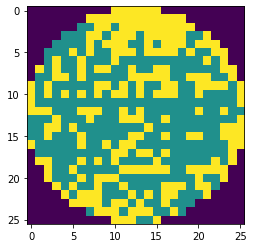

Faulty case : ['Edge-Loc'] 


In [ ]:
plt.imshow(x[36])
plt.show()
print('Faulty case : {} '.format(y[36]))

In [ ]:
x = x.reshape((-1, 26, 26, 1))

In [ ]:
x.shape

(327, 26, 26, 1)

In [ ]:
#불량 클래스
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Edge-Loc : 296
Edge-Ring : 31


웨이퍼 데이터의 각 픽셀에는 웨이퍼가 아닌 0, 1: 정상, 2: 결함을 나타내는 범주형 변수가 있다. 원-핫 인코딩된 단일 범주 데이터를 채널로 사용하여 추가 차원을 확장한다.



In [ ]:
len(x)

327

In [ ]:
#각 채널에 따라 원핫인코딩
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j,int(x[w, i, j])] = 1

In [ ]:
new_x.shape

(327, 26, 26, 3)

##couv autoencoder

In [ ]:
#인고더
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)
Maxpool2D = layers.MaxPool2D()(encode)

#디코더
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#디코더 레이어 연걸
decode = decode_layer_1(Maxpool2D)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [ ]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [ ]:
# start train
# verbose 0이면 출력x, 1이면 자세히, 2이면 함축적 정보
ae.fit(new_x, new_x,
       batch_size=512,
       epochs=10,
       verbose=2)

Train on 327 samples
Epoch 1/10
327/327 - 1s - loss: 0.2346 - 1s/epoch - 4ms/sample
Epoch 2/10
327/327 - 1s - loss: 0.2151 - 689ms/epoch - 2ms/sample
Epoch 3/10
327/327 - 1s - loss: 0.1968 - 705ms/epoch - 2ms/sample
Epoch 4/10
327/327 - 1s - loss: 0.1803 - 727ms/epoch - 2ms/sample
Epoch 5/10
327/327 - 1s - loss: 0.1669 - 700ms/epoch - 2ms/sample
Epoch 6/10
327/327 - 1s - loss: 0.1577 - 722ms/epoch - 2ms/sample
Epoch 7/10
327/327 - 1s - loss: 0.1519 - 708ms/epoch - 2ms/sample
Epoch 8/10
327/327 - 1s - loss: 0.1475 - 707ms/epoch - 2ms/sample
Epoch 9/10
327/327 - 1s - loss: 0.1432 - 707ms/epoch - 2ms/sample
Epoch 10/10
327/327 - 1s - loss: 0.1385 - 727ms/epoch - 2ms/sample


In [ ]:
#오토인코더 모델 층의 일부를 인코더 모델 생성
encoder = models.Model(input_tensor,Maxpool2D)

In [ ]:
#오토인코더 모델 층의 일부로 디코더 모델 생성
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
decoder = models.Model(decoder_input, output_tensor(decode))

In [ ]:
#기존 결함이 있는 웨이퍼 인코딩
encoded_x = encoder.predict(new_x)

#노이즈 첨가
noised_encoded_x = encoded_x+np.random.normal(loc=0,
                                                scale=0.1,
                                                size = (len(encoded_x), 13, 13, 64))

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
###데이터 증강 - 7000개 정도
def gen_data(wafer, label):
    #인코더 웨이퍼
    encoded_x = encoder.predict(wafer)
    gen_x = np.zeros((1, 26, 26, 3))
    
    #7000개 데이터 증강
    for i in range((7000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)

    gen_y = np.full((len(gen_x), 1), label)

    return gen_x[1:], gen_y[1:]

In [ ]:
#모든 결함있는 경우의 데이터를 증강
for f in faulty_case:
    if f == 'none': 
        continue
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]],f)
    new_x = np.concatenate((new_x, gen_x),axis=0)
    y = np.concatenate((y,gen_y))

In [ ]:
print('수정 후 new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

수정 후 new_x shape : (14437, 26, 26, 3), new_y shape : (14437, 1)


In [ ]:
for f in faulty_case:
    print('{} : {}'.format(f, len(y[y==f])))

Edge-Loc : 7400
Edge-Ring : 7037


In [ ]:
# #사이즈 확인
# none_idx = np.where(y=='Edge-Ring')[0][np.random.choice(len(np.where(y=='Edge-Ring')[0]), size=11000)]
# new_x = np.delete(new_x, none_idx, axis=0)
# new_y = np.delete(y, none_idx, axis=0)

In [ ]:
# print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

In [ ]:
# for f in faulty_case:
#     print('{} : {}'.format(f, len(new_y[new_y==f])))

In [ ]:
new_y = y
for i, j in enumerate(faulty_case):
    new_y[new_y==j] = i
# 원핫인코딩
new_y = to_categorical(new_y)

In [ ]:
new_y.shape

(14437, 2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.3,
                                                    random_state=64)

In [ ]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (10105, 26, 26, 3), y : (10105, 2)
Test x: (4332, 26, 26, 3), y : (4332, 2)


##CNN

In [ ]:
def CNN():
    input_shape = (26, 26, 3)
    input = Input(input_shape)

    conv1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input)
    conv2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    conv3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2)

    flat = layers.Flatten()(conv3)

    dense1 = layers.Dense(512, activation='relu')(flat) #512개 레이어 노드
    dense2 = layers.Dense(128, activation='relu')(dense1) #128
    output = layers.Dense(2, activation='softmax')(dense2) #2

    model = models.Model(input, output)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [ ]:
CNN().summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 16)        448       
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        9280      
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       73856     
                                                                 
 flatten (Flatten)           (None, 86528)             0         
                                                                 
 dense (Dense)               (None, 512)               44302848  
                                                                 
 dense_1 (Dense)             (None, 128)               6566

In [ ]:
model = KerasClassifier(build_fn = CNN, epochs=5, batch_size=1024, verbose=2)

<ipython-input-67-48b3d6321f07>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn = CNN, epochs=5, batch_size=1024, verbose=2)


In [ ]:
# # 3-Fold Cross validation
# kfold = KFold(n_splits=3, shuffle=True, random_state=64)
# result = cross_val_score(model, x_train, y_train, cv=kfold)
# print('CNN Cross validation score : {:.5f}'.format(np.mean(result)))

Train on 6736 samples
Epoch 1/5
6736/6736 - 77s - loss: 1.4397 - acc: 0.4987 - 77s/epoch - 11ms/sample
Epoch 2/5
6736/6736 - 75s - loss: 0.6816 - acc: 0.5638 - 75s/epoch - 11ms/sample
Epoch 3/5
6736/6736 - 78s - loss: 0.6523 - acc: 0.6241 - 78s/epoch - 12ms/sample
Epoch 4/5
6736/6736 - 76s - loss: 0.5916 - acc: 0.6777 - 76s/epoch - 11ms/sample
Epoch 5/5
6736/6736 - 75s - loss: 0.4686 - acc: 0.7852 - 75s/epoch - 11ms/sample


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Train on 6737 samples
Epoch 1/5
6737/6737 - 78s - loss: 1.5520 - acc: 0.5173 - 78s/epoch - 12ms/sample
Epoch 2/5
6737/6737 - 75s - loss: 0.6799 - acc: 0.5112 - 75s/epoch - 11ms/sample
Epoch 3/5
6737/6737 - 75s - loss: 0.6622 - acc: 0.6087 - 75s/epoch - 11ms/sample
Epoch 4/5
6737/6737 - 77s - loss: 0.6271 - acc: 0.6363 - 77s/epoch - 11ms/sample
Epoch 5/5
6737/6737 - 75s - loss: 0.5066 - acc: 0.7852 - 75s/epoch - 11ms/sample


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Train on 6737 samples
Epoch 1/5
6737/6737 - 79s - loss: 0.9696 - acc: 0.5063 - 79s/epoch - 12ms/sample
Epoch 2/5
6737/6737 - 78s - loss: 0.6768 - acc: 0.5217 - 78s/epoch - 12ms/sample
Epoch 3/5
6737/6737 - 76s - loss: 0.6081 - acc: 0.7230 - 76s/epoch - 11ms/sample
Epoch 4/5
6737/6737 - 76s - loss: 0.4493 - acc: 0.8056 - 76s/epoch - 11ms/sample
Epoch 5/5
6737/6737 - 76s - loss: 0.3305 - acc: 0.8674 - 76s/epoch - 11ms/sample


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


CNN Cross validation score : 0.84829


In [ ]:
#학습
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=10,
         batch_size=1024,
         )

Train on 10105 samples, validate on 4332 samples
Epoch 1/10
10105/10105 - 130s - loss: 1.1046 - acc: 0.5080 - val_loss: 0.6782 - val_acc: 0.5215 - 130s/epoch - 13ms/sample
Epoch 2/10
10105/10105 - 127s - loss: 0.6671 - acc: 0.5519 - val_loss: 0.6197 - val_acc: 0.7696 - 127s/epoch - 13ms/sample
Epoch 3/10
10105/10105 - 132s - loss: 0.5770 - acc: 0.7254 - val_loss: 0.4892 - val_acc: 0.7581 - 132s/epoch - 13ms/sample
Epoch 4/10
10105/10105 - 129s - loss: 0.3977 - acc: 0.8415 - val_loss: 0.3081 - val_acc: 0.8659 - 129s/epoch - 13ms/sample
Epoch 5/10
10105/10105 - 127s - loss: 0.3461 - acc: 0.8455 - val_loss: 0.4353 - val_acc: 0.8054 - 127s/epoch - 13ms/sample
Epoch 6/10
10105/10105 - 129s - loss: 0.3058 - acc: 0.8679 - val_loss: 0.2890 - val_acc: 0.8751 - 129s/epoch - 13ms/sample
Epoch 7/10
10105/10105 - 131s - loss: 0.2322 - acc: 0.9009 - val_loss: 0.2111 - val_acc: 0.9123 - 131s/epoch - 13ms/sample
Epoch 8/10
10105/10105 - 134s - loss: 0.1873 - acc: 0.9213 - val_loss: 0.1666 - val_acc: 0

In [ ]:
score = model.score(x_test, y_test)
print('Model Accuracy:',score)

Model Accuracy: 0.9559095


In [ ]:
print(f1_score(y_test, result))

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
# cnf_matrix = confusion_matrix(y_test, results)
# np.set_printoptions(precision=2)

# from matplotlib import gridspec
# fig = plt.figure(figsize=(15, 8)) 
# gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

# ## Plot non-normalized confusion matrix
# plt.subplot(gs[0])
# plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# # Plot normalized confusion matrix
# plt.subplot(gs[1])
# plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

# plt.show()


In [ ]:
results = model.predict(x_test)

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
results

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
print(x_test.shape)

(4332, 26, 26, 3)


In [ ]:
print(y_test.shape)

(4332, 2)


In [ ]:
print(results.shape)

(4332,)


In [ ]:
results

array([1, 0, 1, ..., 0, 1, 1])

In [ ]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
y_test1 = y_test.ravel()

In [ ]:
y_test1.shape

(8664,)

In [ ]:
print(y_test.shape)

(4332, 2)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print('\n', classification_report(np.argmax(y_test, axis=-1), np.argmax(results, axis=-1)))

In [ ]:
# 5에폭, 512배치 - 3000개
# Model Accuracy: 0.93213296

In [ ]:
# 5에폭, 512배치 - 3000개
# Model Accuracy: 0.89428425

In [ ]:
# 5에폭, 512배치 - 3000개
# Model Accuracy: 0.7890743613243103